# Overview
* How to use Vision Transformer (ViT) for image classification
* Main idea
    * Split input into small NxN patches
    * Flatten them as a `sequence`
    * Treat them as a `token` similar to NLP

[Blog link](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)

# Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

* Using **tf-addons** mainly to import **AdamW** optimizer

In [2]:
tf.config.list_physical_devices('GPU')

2022-04-21 13:55:03.769676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 13:55:03.777034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 13:55:03.777554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [3]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"Train images shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Train images shape: (50000, 32, 32, 3), Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


# Define hyperparamters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001  # Used in adam weight decay optimizer
batch_size = 256
num_epochs = 100
image_size = 72  # resizing 32x32 to 72x72 by using interpolation
patch_size = 6
num_patches = (image_size // patch_size) ** 2

# ViT parameters
projection_dim = 64
num_heads = 4  # Four attention heads
transformer_units = [
    projection_dim * 2,
    projection_dim
]  # Size fo the transformer layers, related to skip connection
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers in the final classifier

* From `image_size` and `patch_size`, we get and store number of patches in a variable `num_patches`. It will be used when we define the *positional embeddings*.
    * **Positional embedding** -> where in the original image this patch is located. 
* Project patches to `64-dim` feature vectors
    * Concatenated together to form input for the first transformer layer
* Four separate transformations/parameterizations
    * Aggregate the output
* Skip connections are also utilized


# Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2,
                                                     width_factor=0.2
                                                    ),
    ],
    name = "data_augmentation",
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

2022-04-21 13:55:04.602028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 13:55:04.602564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 13:55:04.602912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 13:55:04.603234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

* **Data Augmentation**
    * To prevent *overfitting*
    * In `normalization` we use `adapt` layer
        * [The adapt() method](https://keras.io/guides/preprocessing_layers/)
            * Some preprocessing layers have an internal state that can be computed based on a sample of the training data.
            * Crucially, these layers are **non-trainable**. Their state is not set during training; it must be set **before training**, either by initializing them from a pre-computed constant, or by *adapting* them on data.

# Multilayer Perceptron Implmentation

In [6]:
# Custom mlp with skip connection
# Using keras functional API

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

* Overwriting keras `Layer` object to implement the *patches* layer. 
* This is the layer where we take 72x72 image and then transforming it into a grid of 6x6 patches.


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's visualize patches for a sample image.

Unlike regular `plt.imshow`, We will have to loop through these patches, plot them and have them occupy space in `plt.subplot` indexing.

Image size: 72 X 72
Pmage size: 6 X 6
Patche per image: 144
Elements per patch: 108


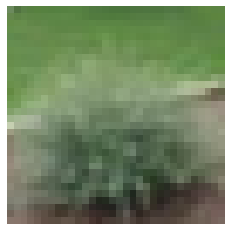

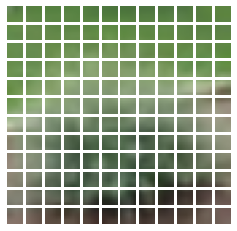

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Pmage size: {patch_size} X {patch_size}")
print(f"Patche per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1) # (nrows, ncols, idx)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

Elements are `108` because each patch is `rgb`, so `6x6x3` results in 108 elements.

# Implement the patch encoding layer

We have a projection of these `patches`, and then we are going to add a learnable `embedding` for the position. This is used in transformer architectures because transformers don't have any sense of the original ordering of the sequence. So we are going to be learning this `embedding` as well.

In our case, we have `144` positional embeddings because we have `144` patches. Each one of these represents a discrete object like 0, 1, 2 up to 144. Sow we are going to map this into an **embedding table** that transform that 0, 1, 2 into a `vector` or the same projection dimension as we are transforming our `patches`.

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dims):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT Model

The Vit model consists of multiple transformer blocks which uses the `layers.MultiHeadAttention` layer as a self-attention mechanism applied to the sequence of patches. The transformer blocks produce a `[batch_size, num_patches, projection_dim]` tensor, which is processed via a classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929), which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with `layers.Flatten()` and used as the image representation input to the classifier head. Note that the `layers.GlobalAveragePooling1D` layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [10]:
# Using keras functional API

def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches 
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, 
                                                    dropout=0.1)(x1, x1)
        # Skip conenction 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])
    
    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs = logits)
    
    return model

# Compile, train and evaluate the model

In [11]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate= learning_rate,
                                    weight_decay=weight_decay)
    model.compile(optimizer=optimizer,
                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                         keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')
                         ])
    
    checkpoint_filepath = "./checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=1)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    
    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_split=0.1,
                        callbacks=[checkpoint_callback, tensorboard_callback]
                       )
    
    model.load_weights(checkpoint_filepath)
    loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top-5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    return history

`from_logits=true` because we did not apply *softmax* in the architecture. This option will automatically apply *softmax* to the `logits`.

Using `SparseTopKCategoricalAccuracy` to see that at least the prediction is in top-5 labels. This gives us more information about the performance of the model.

We can also add other callback options like *EarlyStopping, LearningRateScheduler* and so on. A list of various callback option is available [here](https://keras.io/api/callbacks/).

In [12]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
______________________________________________________________________________________________

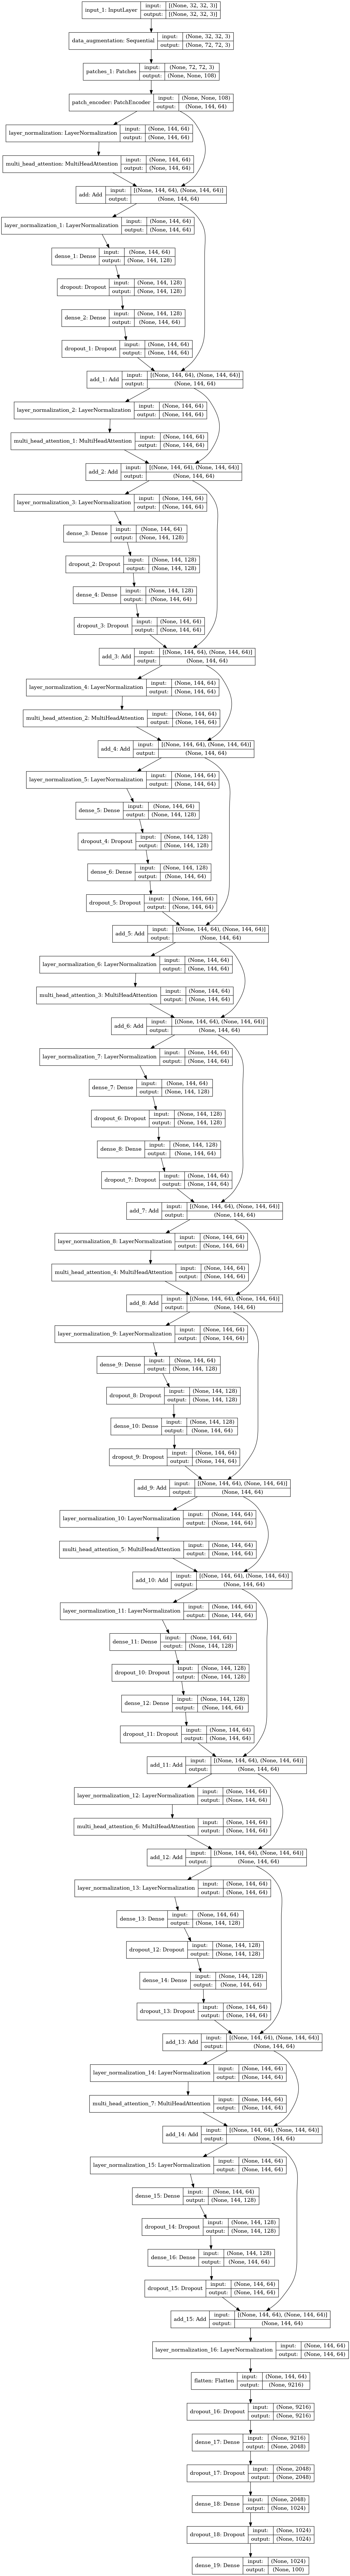

In [13]:
tf.keras.utils.plot_model(vit_classifier, show_shapes=True)

In [24]:
history = run_experiment(vit_classifier)

2022-04-13 12:12:19.890237: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 12:12:19.890258: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-13 12:12:19.890384: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-04-13 12:12:19.890792: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
  1/176 [..............................] - ETA: 17:43 - loss: 7.7754 - accuracy: 0.0195 - top-5-accuracy: 0.0508

2022-04-13 12:12:26.192444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-13 12:12:26.390660: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-13 12:12:26.390686: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-13 12:12:26.390725: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  3/176 [..............................] - ETA: 29s - loss: 7.1134 - accuracy: 0.0195 - top-5-accuracy: 0.0521

2022-04-13 12:12:26.500171: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-13 12:12:26.510922: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-13 12:12:26.514486: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-13 12:12:26.518667: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_04_13_12_12_26

2022-04-13 12:12:26.519149: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_04_13_12_12_26/trojan.trace.json.gz
2022-04-13 12:12:26.544691: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_04_13_12_12_26

2022-04-13 12:12:26.549788: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

176/176 [==============================] - 26s 116ms/step - loss: 4.4812 - accuracy: 0.0447 - top-5-accuracy: 0.1544 - val_loss: 3.9400 - val_accuracy: 0.1040 - val_top-5-accuracy: 0.3022
Epoch 2/100
176/176 [==============================] - 20s 111ms/step - loss: 3.9535 - accuracy: 0.0918 - top-5-accuracy: 0.2867 - val_loss: 3.6252 - val_accuracy: 0.1522 - val_top-5-accuracy: 0.3938
Epoch 3/100
176/176 [==============================] - 20s 111ms/step - loss: 3.6985 - accuracy: 0.1293 - top-5-accuracy: 0.3633 - val_loss: 3.3816 - val_accuracy: 0.2026 - val_top-5-accuracy: 0.4716
Epoch 4/100
176/176 [==============================] - 20s 112ms/step - loss: 3.5251 - accuracy: 0.1591 - top-5-accuracy: 0.4144 - val_loss: 3.2226 - val_accuracy: 0.2208 - val_top-5-accuracy: 0.5150
Epoch 5/100
176/176 [==============================] - 20s 111ms/step - loss: 3.3936 - accuracy: 0.1805 - top-5-accuracy: 0.4560 - val_loss: 3.0722 - val_accuracy: 0.2428 - val_top-5-accuracy: 0.5370
Epoch 6/100


Epoch 42/100
176/176 [==============================] - 19s 110ms/step - loss: 1.3319 - accuracy: 0.6194 - top-5-accuracy: 0.8906 - val_loss: 1.8281 - val_accuracy: 0.5204 - val_top-5-accuracy: 0.8066
Epoch 43/100
176/176 [==============================] - 19s 110ms/step - loss: 1.3164 - accuracy: 0.6216 - top-5-accuracy: 0.8934 - val_loss: 1.8424 - val_accuracy: 0.5222 - val_top-5-accuracy: 0.8040
Epoch 44/100
176/176 [==============================] - 19s 110ms/step - loss: 1.2981 - accuracy: 0.6260 - top-5-accuracy: 0.8954 - val_loss: 1.8579 - val_accuracy: 0.5198 - val_top-5-accuracy: 0.8086
Epoch 45/100
176/176 [==============================] - 19s 110ms/step - loss: 1.2701 - accuracy: 0.6350 - top-5-accuracy: 0.9006 - val_loss: 1.8405 - val_accuracy: 0.5258 - val_top-5-accuracy: 0.8082
Epoch 46/100
176/176 [==============================] - 19s 110ms/step - loss: 1.2484 - accuracy: 0.6382 - top-5-accuracy: 0.9038 - val_loss: 1.8540 - val_accuracy: 0.5246 - val_top-5-accuracy: 0.

Epoch 83/100
176/176 [==============================] - 21s 119ms/step - loss: 0.8582 - accuracy: 0.7452 - top-5-accuracy: 0.9534 - val_loss: 1.8868 - val_accuracy: 0.5446 - val_top-5-accuracy: 0.8172
Epoch 84/100
176/176 [==============================] - 21s 119ms/step - loss: 0.8610 - accuracy: 0.7432 - top-5-accuracy: 0.9527 - val_loss: 1.8873 - val_accuracy: 0.5434 - val_top-5-accuracy: 0.8164
Epoch 85/100
176/176 [==============================] - 21s 119ms/step - loss: 0.8250 - accuracy: 0.7534 - top-5-accuracy: 0.9555 - val_loss: 1.9244 - val_accuracy: 0.5444 - val_top-5-accuracy: 0.8164
Epoch 86/100
176/176 [==============================] - 21s 118ms/step - loss: 0.8337 - accuracy: 0.7518 - top-5-accuracy: 0.9559 - val_loss: 1.8883 - val_accuracy: 0.5404 - val_top-5-accuracy: 0.8170
Epoch 87/100
176/176 [==============================] - 20s 116ms/step - loss: 0.8284 - accuracy: 0.7514 - top-5-accuracy: 0.9555 - val_loss: 1.9044 - val_accuracy: 0.5370 - val_top-5-accuracy: 0.

After 100 epochs, the ViT model achieves around 55% accuracy and 82% top-5 accuracy on the test data. These are not competitive results on CIFAR-100 dataset, as **ResNet50V2** trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in this paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can 

* Try to train the model for more epochs
* Use a larger number of Transformer layers 
* Resize the input images
* Change the `patch_size`
* Increase the projection dimensions

Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameter such as the learning rate schedule, optimizer, weight decay, etc. In practice, it is recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

# Visualizing training process

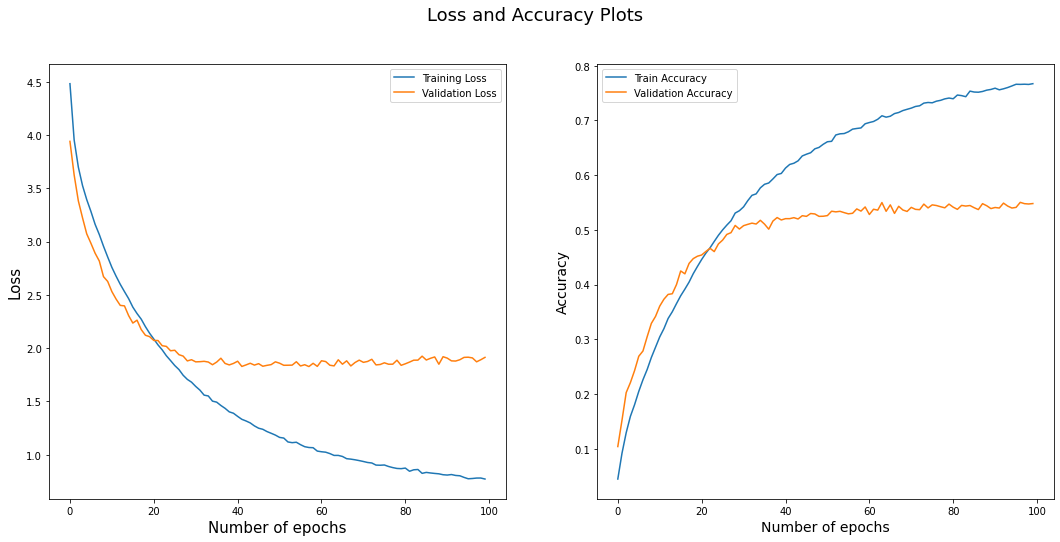

In [27]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

# Testing

In [14]:
checkpoint_filepath = "./checkpoint"
model = vit_classifier
model.load_weights(checkpoint_filepath)

y_pred = vit_classifier.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.array(tf.squeeze(y_test)) # Removes extra dimension in y_test

# Calculate accuracy
test_accuracy = np.count_nonzero(y_pred == y_test)/ len(y_test)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

 21/313 [=>............................] - ETA: 2s

2022-04-21 13:55:20.165426: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 3s 7ms/step
Test accuracy: 55.06%


Alternatively, we can use `sklearn` to calculate accuracy.

In [15]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

Test Accuracy:  55.06 %


# Visualizing Predictions

In [16]:
# Labels list

str_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 
              'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 
              'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 
              'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 
              'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 
              'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 
              'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 
              'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 
              'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 
              'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 
              'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
              'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 
              'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
              'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 
              'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 
              'woman', 'worm']

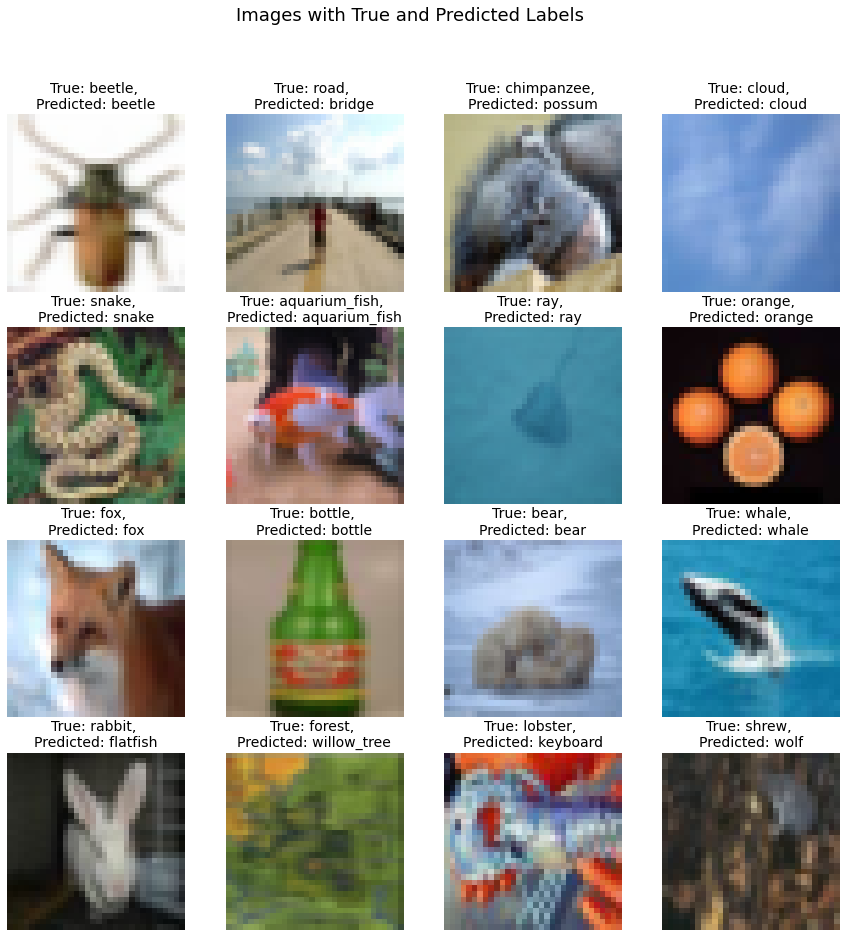

In [23]:
# Plot some predictions
plt.rcParams["figure.figsize"] = (15,15)

num_row = 4
num_col = 4

image_id = np.random.randint(0, len(x_test), num_row * num_col)
fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i * num_col) + j
        axes[i,j].imshow(x_test[image_id[k]])
        axes[i,j].set_title(f"True: {str_labels[y_test[image_id[k]]]}, \nPredicted: {str_labels[y_pred[image_id[k]]]}", fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

# Checking ground-truth labels

I faced some issue in displaying results. My **ground-truth** labels are not in line with the displayed images. So need to check if there is an issue with `str_labels` list or the issue is in my plotting function.

Ground-truth label and class:  21 -> chimpanzee
Predicted label and class:  21 -> chimpanzee


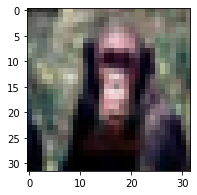

In [26]:
idx = 24

plt.rcParams["figure.figsize"] = (3,3)
plt.imshow(x_test[idx])
print("Ground-truth label and class: ", y_test[idx], "->", str_labels[y_test[idx]])
print("Predicted label and class: ", y_pred[idx], "->", str_labels[y_pred[idx]])

Results show that ground labels are in accordance with `str_labels` list. So the issue is in my plotting function. I copied it from another source. Need to write my own function now.